In [48]:
# The code was removed by Watson Studio for sharing.

In [196]:
test_data.count()

543705

In [200]:
# Standard imports used across quantitative analysis
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as mpl
mpl.rcParams['agg.path.chunksize'] = 100000
from matplotlib.gridspec import GridSpec

In [72]:
# Rejecting column names used within the StringIndexer
cnames = ['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'status', 'userAgent', 'userId']
col_names = []
col_names2 = []
for each in cnames:
    col_names.append(each+'Index')
    col_names2.append(each+'Index')
col_names2.extend(['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts'])

In [77]:
# Building pipeline for kmeans clustering
indexer = StringIndexer(inputCols = cnames, outputCols = col_names, handleInvalid = 'skip')
vecAssembler = VectorAssembler(inputCols=col_names2, outputCol = 'features')
standardscaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
kMeans = KMeans(featuresCol = 'scaled_features', predictionCol = 'prediction', k = 3)
pipeline = Pipeline(stages = [indexer, vecAssembler, standardscaler, kMeans])

In [78]:
# Predicting clusters
model = pipeline.fit(test_data)
k_df = model.transform(test_data)

In [201]:
k_evaluator = ClusteringEvaluator()

In [79]:
# Evaluating the accuracy of the cluster placements against the levelIndex of the dataset
# The data set only contains 2 groups, yet the kmeans created k = 3 cluster to correspond the churn rate analysis, of users who may downgrade, stay current, or upgrade service
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'levelIndex')
k_df = k_df.withColumn("prediction", col("prediction").cast("double"))
multi_evaluator.evaluate(k_df)

0.2551845647724289

In [202]:
k_evaluator.evaluate(k_df)

-0.034124332780782723

In [80]:
# Buidling a second pipeline for comparison of the kmeans clustering of k = 2.
indexer = StringIndexer(inputCols = cnames, outputCols = col_names, handleInvalid = 'skip')
vecAssembler = VectorAssembler(inputCols=col_names2, outputCol = 'features')
standardscaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
kMeans = KMeans(featuresCol = 'scaled_features', predictionCol = 'prediction', k = 2)
pipeline2 = Pipeline(stages = [indexer, vecAssembler, standardscaler, kMeans])
model2 = pipeline2.fit(test_data)
k_df2 = model2.transform(test_data)
k_df2 = k_df2.withColumn("prediction", col("prediction").cast("double"))
multi_evaluator.evaluate(k_df2)

0.7844130846227866

In [203]:
k_evaluator.evaluate(k_df2)

0.17595644158136367

In [84]:
# Building a regression analysis pipelne for final classification
vecAssembler2 = VectorAssembler(inputCols=['ts'], outputCol = 'feature', handleInvalid = 'skip')
glm = GeneralizedLinearRegression(featuresCol = 'feature', labelCol = 'length', predictionCol='regression_prediction')
pipe2 = Pipeline(stages = [vecAssembler2, glm])
regEval = RegressionEvaluator(predictionCol = 'regression_prediction', labelCol = 'length')

In [185]:
vecAssembler3 = VectorAssembler(inputCols=['ts'], outputCol = 'feature', handleInvalid = 'skip')
glm2 = GeneralizedLinearRegression(featuresCol = 'feature', labelCol = 'length', predictionCol='regression_prediction', family = 'gaussian')
pipe3 = Pipeline(stages = [vecAssembler3, glm2])
grid = ParamGridBuilder() \
    .addGrid(glm.link, ['gaussian', 'identity', 'log', 'inverse']) \
    .build()
cv = CrossValidator(estimator = pipe3, estimatorParamMaps=grid, evaluator = regEval, parallelism = 2)

In [81]:
# Split the kmeans predicitons into a data frame of only free users
# Splt data into training and testing sets.
k_df_free = k_df.filter(k_df.level == 'free')
k_df_free_train, k_df_free_test = k_df_free.randomSplit([.7, .3])

In [181]:
# Break data into 3 groups, 0,1,2
# and evaluate the regression
k_df_free_train_0 = k_df_free_train.filter(k_df_free_train.prediction == 0)
k_df_free_test_0 = k_df_free_test.filter(k_df_free_test.prediction == 0)

glm_model_free_train_0 = pipe2.fit(k_df_free_train_0)
glm_free_train_0 = glm_model_free_train_0.transform(k_df_free_test_0)
glm_free_train_0_e = regEval.evaluate(glm_free_train_0)

cv_model_free_0 = cv.fit(k_df_free_train_0)
cv_free_0 = cv_model_free_0.transform(k_df_free_test_0)
cv_free_0_e = regEval.evaluate(cv_free_0)

print(glm_free_train_0_e, cv_free_0_e)

92.69822905411358 92.69822905411358


In [182]:
# Break data into 3 groups, 0,1,2
# and evaluate the regression
k_df_free_train_1 = k_df_free_train.filter(k_df_free_train.prediction == 1)
k_df_free_test_1 = k_df_free_test.filter(k_df_free_test.prediction == 1)
glm_model_free_train_1 = pipe2.fit(k_df_free_train_1)
glm_free_train_1 = glm_model_free_train_1.transform(k_df_free_test_1)
glm_free_train_1_e = regEval.evaluate(glm_free_train_1)
cv_model_free_1 = cv.fit(k_df_free_train_1)
cv_free_1 = cv_model_free_1.transform(k_df_free_test_1)
cv_free_1_e = regEval.evaluate(cv_free_1)

print(glm_free_train_1_e, cv_free_1_e)

94.07115179674082 94.07115179674082


In [186]:
# Break data into 3 groups, 0,1,2
# and evaluate the regression
k_df_free_train_2 = k_df_free_train.filter(k_df_free_train.prediction == 2)
k_df_free_test_2 = k_df_free_test.filter(k_df_free_test.prediction == 2)
glm_model_free_train_2 = pipe2.fit(k_df_free_train_2)
glm_free_train_2 = glm_model_free_train_2.transform(k_df_free_test_2)
glm_free_train_2_e = regEval.evaluate(glm_free_train_2)
cv_model_free_2 = cv.fit(k_df_free_train_2)
cv_free_2 = cv_model_free_2.transform(k_df_free_test_2)
cv_free_2_e = regEval.evaluate(cv_free_2)
print(glm_free_train_2_e, cv_free_2_e)

129.4478618979109 129.4478618979109


In [187]:
# Split the kmeans predicitons into a data frame of only paid users
# Splt data into training and testing sets.
k_df_paid = k_df.filter(k_df.level == 'paid')
k_df_paid_train, k_df_paid_test = k_df_paid.randomSplit([.7, .3])

In [188]:
# Break data into 3 groups, 0,1,2
# and evaluate the regression
k_df_paid_train_0 = k_df_paid_train.filter(k_df_paid_train.prediction == 0)
k_df_paid_test_0 = k_df_paid_test.filter(k_df_paid_test.prediction == 0)
glm_model_paid_train_0 = pipe2.fit(k_df_paid_train_0)
glm_paid_train_0 = glm_model_paid_train_0.transform(k_df_paid_test_0)
glm_paid_train_0_e = regEval.evaluate(glm_paid_train_0)

cv_model_paid_0 = cv.fit(k_df_paid_train_0)
cv_paid_0 = cv_model_paid_0.transform(k_df_paid_test_0)
cv_paid_0_e = regEval.evaluate(cv_paid_0)
print(glm_paid_train_0_e, cv_paid_0_e)

97.59845302137859 97.59845302137859


In [189]:
# Break data into 3 groups, 0,1,2
# and evaluate the regression
k_df_paid_train_1 = k_df_paid_train.filter(k_df_paid_train.prediction == 1)
k_df_paid_test_1 = k_df_paid_test.filter(k_df_paid_test.prediction == 1)
glm_model_paid_train_1 = pipe2.fit(k_df_paid_train_1)
glm_paid_train_1 = glm_model_paid_train_1.transform(k_df_paid_test_1)
glm_paid_train_1_e = regEval.evaluate(glm_paid_train_1)

cv_model_paid_1 = cv.fit(k_df_paid_train_1)
cv_paid_1 = cv_model_paid_1.transform(k_df_paid_test_1)
cv_paid_1_e = regEval.evaluate(cv_paid_1)
print(glm_paid_train_1_e, cv_paid_1_e)

95.02944946878958 95.02944946878958


In [190]:
# Break data into 3 groups, 0,1,2
# and evaluate the regression
k_df_paid_train_2 = k_df_paid_train.filter(k_df_paid_train.prediction == 2)
k_df_paid_test_2 = k_df_paid_test.filter(k_df_paid_test.prediction == 2)
glm_model_paid_train_2 = pipe2.fit(k_df_paid_train_2)
glm_paid_train_2 = glm_model_paid_train_2.transform(k_df_paid_test_2)
glm_paid_train_2_e = regEval.evaluate(glm_paid_train_2)

cv_model_paid_2 = cv.fit(k_df_paid_train_2)
cv_paid_2 = cv_model_paid_2.transform(k_df_paid_test_2)
cv_paid_2_e = regEval.evaluate(cv_paid_2)
print(glm_paid_train_2_e, cv_paid_2_e)

116.13094809074853 116.13094809074853


In [304]:
for each in data:
    print(each)

[92.69822905411358, 92.69822905411358]
[94.07115179674082, 94.07115179674082]
[129.4478618979109, 129.4478618979109]
[97.59845302137859, 97.59845302137859]
[95.02944946878958, 95.02944946878958]
[116.13094809074853, 116.13094809074853]


In [262]:
import matplotlib.colors as mcolors
clist = [(0, "red"), (0.125, "red"), (0.25, "orange"), (0.5, "green"), 
         (0.7, "green"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

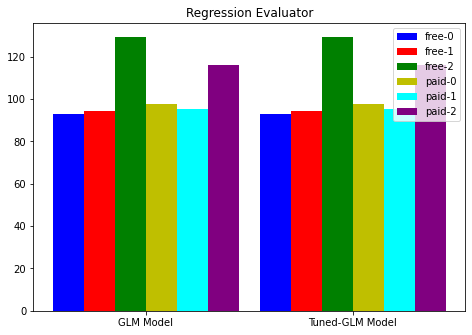

In [328]:
# glm_free_train_0_e, cv_free_0_e
# glm_free_train_1_e, cv_free_1_e
# glm_free_train_2_e, cv_free_2_e

# glm_paid_train_0_e, cv_paid_0_e
# glm_paid_train_1_e, cv_paid_1_e
# glm_paid_train_2_e, cv_paid_2_e
data = [[glm_free_train_0_e, cv_free_0_e], \
        [glm_free_train_1_e, cv_free_1_e], \
        [glm_free_train_2_e, cv_free_2_e], \
        [glm_paid_train_0_e, cv_paid_0_e], \
        [glm_paid_train_1_e, cv_paid_1_e], \
        [glm_paid_train_2_e, cv_paid_2_e]]
fig1 = mpl.figure()
X = np.arange(2)
ax_reg = fig1.add_axes([0, 0, 1, 1])
dimw = .75 / len(data[0])
#students = [glm_free_train_0_e, glm_free_train_1_e, glm_free_train_2_e, glm_paid_train_0_e, glm_paid_train_1_e, glm_paid_train_2_e]
ax_reg.bar(X + 0.00, data[0], color = 'b', width = .15)
ax_reg.bar(X + .15, data[1], color = 'r', width = .15)
ax_reg.bar(X + .3, data[2], color = 'g', width = .15)
ax_reg.bar(X + .45, data[3], color = 'y', width = .15)
ax_reg.bar(X + .6, data[4], color = 'cyan', width = .15)
ax_reg.bar(X + .75, data[5], color = 'purple', width = .15)
ax_reg.set_xticks(X + .75 / 2)
ax_reg.set_xticklabels(map(str, ('GLM Model', 'Tuned-GLM Model')))
#ax_reg.set_xticklabels(X, ('free-0', 'free-1', 'free-2', 'paid-0', 'paid-1', 'paid-2')
ax_reg.set_title("Regression Evaluator")
ax_reg.legend(labels = ['free-0', 'free-1', 'free-2', 'paid-0', 'paid-1', 'paid-2'], loc = 'upper right')
mpl.show()

In [191]:
# convert to pandas for plot
glm_free_train_0_df = glm_free_train_0.select('ts', 'length', 'regression_prediction').toPandas()
glm_free_train_1_df = glm_free_train_1.select('ts', 'length', 'regression_prediction').toPandas()
glm_free_train_2_df = glm_free_train_2.select('ts', 'length', 'regression_prediction').toPandas()

In [192]:
# convert to pandas for plot
glm_paid_train_0_df = glm_paid_train_0.select('ts', 'length', 'regression_prediction').toPandas()
glm_paid_train_1_df = glm_paid_train_1.select('ts', 'length', 'regression_prediction').toPandas()
glm_paid_train_2_df = glm_paid_train_2.select('ts', 'length', 'regression_prediction').toPandas()

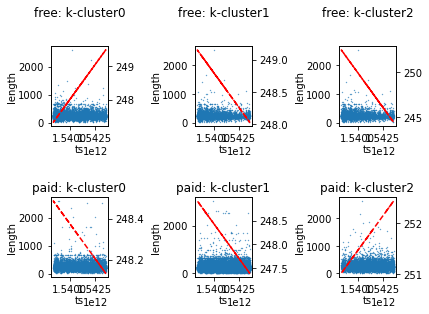

In [193]:
fig, axs = mpl.subplots(2, 3)
axs1 = axs[0, 0].twinx()
axs2 = axs[0, 1].twinx()
axs3 = axs[0, 2].twinx()

axs4 = axs[1, 0].twinx()
axs5 = axs[1, 1].twinx()
axs6 = axs[1, 2].twinx()

r = 0
while r < 2:
    cm = 0
    while cm < 3:
        if r == 0:
            axs[r, cm].set_title('free: k-cluster' + str(cm), pad =30)
            axs[r, cm].set_xlabel('ts', labelpad = 1)
            axs[r, cm].set_ylabel('length', labelpad = 1)
        else:
            axs[r, cm].set_title('paid: k-cluster' + str(cm))
            axs[r, cm].set_xlabel('ts', labelpad = 1)
            axs[r, cm].set_ylabel('length', labelpad = 1)
        cm += 1
    r += 1
    
axs[0, 0].scatter(glm_free_train_0_df.ts, glm_free_train_0_df.length, s = .1)
axs1.plot(glm_free_train_0_df.ts, glm_free_train_0_df.regression_prediction, "r--")
axs[0, 1].scatter(glm_free_train_1_df.ts, glm_free_train_1_df.length, s = .1)
axs2.plot(glm_free_train_1_df.ts, glm_free_train_1_df.regression_prediction, "r--")
axs[0, 2].scatter(glm_free_train_1_df.ts, glm_free_train_1_df.length, s = .1)
axs3.plot(glm_free_train_2_df.ts, glm_free_train_2_df.regression_prediction, "r--")

z1 = np.polyfit(glm_free_train_0_df.ts, glm_free_train_0_df.length, 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(glm_free_train_1_df.ts, glm_free_train_1_df.length, 1)
p2 = np.poly1d(z2)
z3 = np.polyfit(glm_free_train_2_df.ts, glm_free_train_2_df.length, 1)
p3 = np.poly1d(z3)

free_slope = [p1, p2, p3]

axs[1, 0].scatter(glm_paid_train_0_df.ts, glm_paid_train_0_df.length, s = .1)
axs4.plot(glm_paid_train_0_df.ts, glm_paid_train_0_df.regression_prediction, "r--")

axs[1, 1].scatter(glm_paid_train_1_df.ts, glm_paid_train_1_df.length, s = .1)
axs5.plot(glm_paid_train_1_df.ts, glm_paid_train_1_df.regression_prediction, "r--")

axs[1, 2].scatter(glm_paid_train_2_df.ts, glm_paid_train_2_df.length, s = .1)
axs6.plot(glm_paid_train_2_df.ts, glm_paid_train_2_df.regression_prediction, "r--")

z1 = np.polyfit(glm_paid_train_0_df.ts, glm_paid_train_0_df.length, 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(glm_paid_train_1_df.ts, glm_paid_train_1_df.length, 1)
p2 = np.poly1d(z2)
z3 = np.polyfit(glm_paid_train_2_df.ts, glm_paid_train_2_df.length, 1)
p3 = np.poly1d(z3)

paid_slope = [p1, p2, p3]

mpl.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=1.5,  
                    hspace=0.9) 

In [194]:
count = 0
analysis = ['These users will stay', 'these might leave altogether', 'these users might downgrade']
print("Free Users:")
print("-----------")
for each in free_slope:
    print("Cluster", count, "has a slope of", each[1], 'indicating: ')
    print("    ", analysis[count])
    count += 1

Free Users:
-----------
Cluster 0 has a slope of 6.289437943424498e-11 indicating: 
     These users will stay
Cluster 1 has a slope of -1.241581595323732e-09 indicating: 
     these might leave altogether
Cluster 2 has a slope of -2.192414257422613e-09 indicating: 
     these users might downgrade


In [195]:
# The above plot would yields our data for further analysis. Three clusters within the free dataset users, has cluster 0 \
# with a positive trend line, and clusters 1, and 2 with negative length of usage.  We compare the slopes for a full analysis.
count = 0
analysis = ['these users probably leave the service altogether', 'these will continue free service', 'these users might upgrade']
print("Paid Users:")
print("-----------")
for each in paid_slope:
    print("Cluster", count, "has a slope of", each[1], 'indicating: ')
    print("    ", analysis[count])
    count += 1

Paid Users:
-----------
Cluster 0 has a slope of 1.1538995308207522e-10 indicating: 
     these users probably leave the service altogether
Cluster 1 has a slope of -3.4643385110004956e-10 indicating: 
     these will continue free service
Cluster 2 has a slope of -5.450659339330377e-10 indicating: 
     these users might upgrade
